# Machine Learning Algorithm Analysis

The dataset from WiDS was analyzed using the following unsupervised and supervised methods to predict the energy use of buildings:

1. t-SNE (t-distributed stochastic neighbor embedding)
2. K Means Clustering
3. Random Forest
4. XGBoost
5. CatBoost - for non-encoded categorical data in a dataset

The results in RMSE are displayed in the table below, but in general, the CatBoost algorithm was most performant, with RMSE scores in the high 20's.  KNN Regressor was the least performant, with RMSE scores between 45 - 46, depending on tuning and cross-validation settings.  Random Forest was more performant than KNN with scores around 45.  XGBoost with some tuning scored a RMSE around 39.  The CatBoost performed better than XGBoost.  

Based on the initial analysis using unsupervised learning, both the t-SNE and K Means showed that the clusters were not cleanly separating, even though there was eventual separation in the clusters, the clusters were not as tightly packed.  This suggests that the data, even when reduced to two factors does not explain the majority of the variation in the data.  The pre-processed dataset that was used for unsupervised learning already had feature reduction techniques applied, but due to the distribution of clusters from both analyses, I further processed the data and dropped additional fields.  I believe the variance is due to the one-hot-encoded categorical variable for 'facility-type'.  There were 60 facility types listed, making for a large number of features added once it was one-hot-encoded.  Furthermore, there were additional categorical fields that were also one-hot-encoded, but their features were not as numerous.

Therefore, the initial pre-processed dataset (called train) was analyzed using the various techniques mentioned, but a second dataset was also used that had more features dropped (called energy_df), as a comparison and also as a means to reduce error (lower RMSE) in the model and make better predictions.

Over and under-fitting of the models was analyzed in each model run, and overall, the KNN and Random Forest had less variation between train and test than the XGBoost.  Although XGBoost was more performant, the model overfit the data by a substantial amount. As a result, I decided that CatBoost might be helpful.  Since the large number of encoded categorical variables nearly doubled the variable count, I thought that CatBoost could handle the categorical variables better (they don't need to be encoded to go into the model).  Indeed, CatBoost was more performant, I achieved an **RMSE of 28.95** but it came at a cost of over-fitting (train was more performant than test): In R2 vales, CatBoost wouldn't output RMSE on model.score -- train: 0.70, test: 0.44.

### Over/underfitting results:

#### KNN
- Grid training set score after tuning: 43.78
- Grid test set score after tuning: 47.78

#### Random Forest
- Grid training set score after tuning: 31.03
- Grid test set score after tuning: 47.17

#### XGBoost
- Grid training set score after tuning: 8.29
- Grid test set score after tuning: 39.19

#### CatBoost (in R2 not RMSE)
- Grid training set score after tuning: 0.7059
- Grid test set score after tuning: 0.440

In conclusion, the original dataset from WiDS, by itself, does not have enough explanatory power and creates models with higher error or overfitted models.  Even with pre-processing the data still create a model with what I consider mediocre predictive power.  However, on the leaderboard for the competition the best performing teams, which are professional data scientists from international universities scored an RMSE around 18.  I have reviewed the documentation from previous WiDS competitions and it seems that the competitors usually create many new variables from a combined set of variables from the data.  I'm unclear of what the best approach is when combining variables, but I did attempt to do so when I created temperatures from the median for the monthly reported min, max and averages, then summed these values.  This was my feature reduction technique, reduction of colinearity, and creating new information.  I've seen models where they will combine categorical data with numeric, but I'm not clear on the technique they use to make the best judgements about these combinations.  However, I see that they test many of the new variables and drop any that do not provide additional gains for the model.  These will be next steps for this analysis and for other datathons/competitions for me in the future.  I am also looking forward to the final results of the competition to see how others carried out this specific analysis and to learn from their methodology.


## Overview of Supervised Model Outcomes

|Model||dataset||Unique Characteristics||Validation RMSE|
|---:||---:||---:||:---|
|KNN||train||80% PCA, tuned neighbors(23), standardized, cv=2||46.78|
|KNN||train||95% PCA, tuned neighbors(23), standardized, cv=2||46.38|
|KNN||train||95% PCA, tuned neighbors(19), normalized,standardized, cv=2||46.40|
|KNN||energy||no PCA, tuned neighbors(19), normalized,standardized, cv=2||46.40|
|KNN||energy||no PCA, tuned neighbors(23), normalized,standardized, cv=2||46.57|
|KNN||train||no PCA, tuned neighbors(21), normalized,standardized, cv=4||46.00|
|KNN||train||no PCA, tuned neighbors(23), normalized,standardized, cv=10||45.76|
|Random Forest||train||95% PCA, tuned, standardized, cv=2||45.06|
|XGBoost||train||no PCA, tuned, standardized, cv=4||39.28|
|XGBoost||train||no PCA, tuned, normalized, cv=4||39.44|
|CatBoost||train-categorical||no PCA, minmaxScaler,standardized, iterations||39.15|
|CatBoost||energy-categorical||no PCA, minmaxScaler,normalized, iterations=1000,learning_rate=0.5||**28.95**|




In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, normalize, Normalizer, PowerTransformer, MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb #LGBMRegressor()

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

### Import preprocessed data

In [37]:
#import preprocessed data
train = pd.read_csv('train_preprocessed.csv')
test = pd.read_csv('test_preprocessed.csv')

energy_df = pd.read_csv('energy_prepared.csv')

# Unsupervised Learning Techniques
-------------

### t-SNE (t-distributed stochastic neighbor embedding)

There are 90+ features in the dataset. A clustering algorithm was used to better understand the data.  It takes the high dimensionality of the dataset and reduces it for visualization, but still retains much of the original information.  This will help compare features across the 2D distribution.

Results:  After running the t-SNE, it is clear that the data are very disparate, and do not form clean clusters.  I've since gone back and preprocessed a bit more, removing about 30 additional features, many of them are categorical encoded features, which were not included in the original t-SNE, so there won't be an additional t-SNE model run with the newer data.


In [3]:
#pull in categorical data prior to one-hot-encoding to use in 'hue' coloring in SNS graphs
orig_categorical = pd.read_csv('train_before_ohe.csv')
categorical_df = pd.DataFrame(orig_categorical[['Year_Factor','State_Factor', 
                                                'building_class', 'facility_type']])


def create_tsne():
    '''Create t-SNE model'''
    #scale the data
    sc = StandardScaler()
    scaled_tsne = sc.fit_transform(train)
    print('working on create_tsne now...')
    m = TSNE(perplexity=400, n_iter=3000, early_exaggeration=12, verbose=0) 
    #fit/transform tsne model
    tsne_features = m.fit_transform(scaled_tsne)
    #features = tsne_features
    tsne_add_categorical(tsne_features)
    #return tsne_features and get reduction size
    print(tsne_features.shape)
    
def tsne_add_categorical(features):    
    '''add categorical data to the tsne features created in function create_tsne'''
    # add categorical data to tsne data
    #features = create_tsne(tsne_features)
    tsne_df = pd.DataFrame(features,columns=['feature_1','feature_2']) #call other function
    tsne_all = tsne_df.join(categorical_df)
    #data = tsne_all
    tsne_graph(tsne_all) #was data
    print('completed tsne_add_categorical function...')
    

def tsne_graph(data):
    '''create seaborn joint plot of the t-SNE results and overlay categorical data as hue'''
    sns.jointplot(data=data,x='feature_1', y='feature_2', hue='State_Factor',height=10)

working on create_tsne now...
completed tsne_add_categorical function...
(75747, 2)


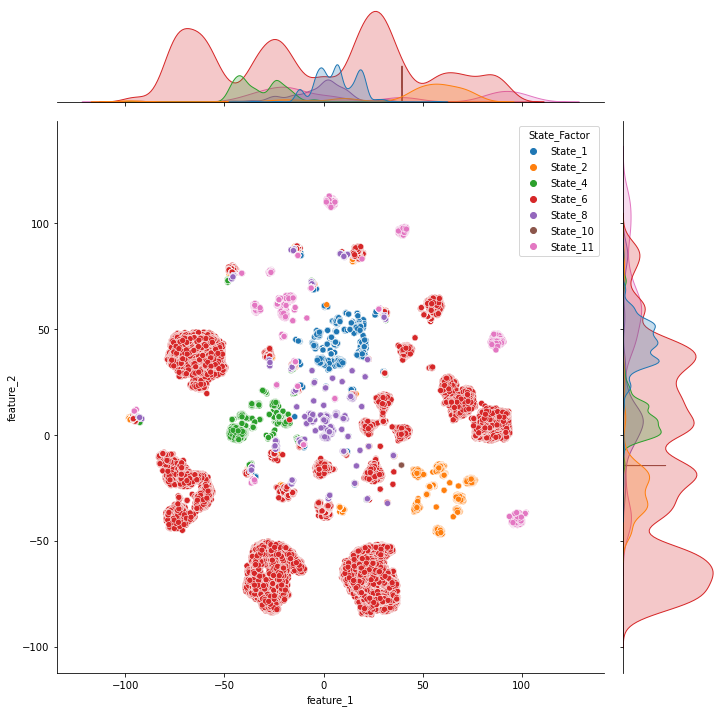

In [4]:
create_tsne()

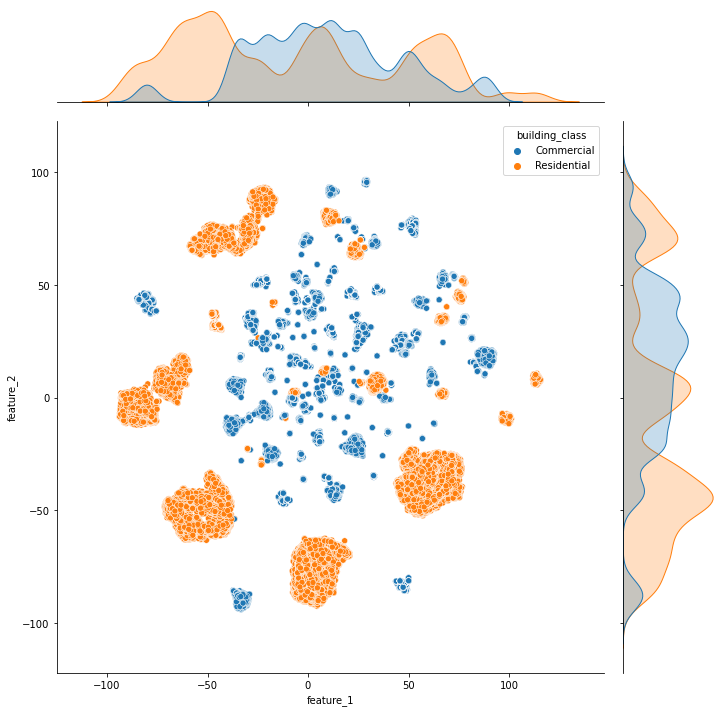

In [23]:
building_class = sns.jointplot(data=tsne_all,x="feature_1", y="feature_2", hue='building_class',height=10)

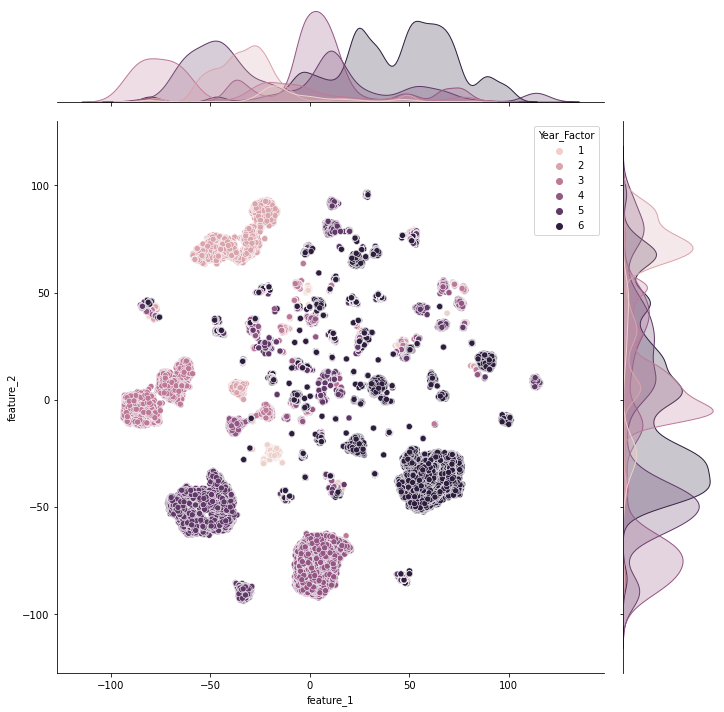

In [24]:
year_factor = sns.jointplot(data=tsne_all,x="feature_1", y="feature_2", hue='Year_Factor',height=10)

## K Means Clustering

Since the t-SNE method did not bring as much clarity to the dataset as I expected, I ran a K Means clustering usng PCA to see how the clusters separated with this method.  Again, it was not suprising that the clusters aren't very clear, although better than t-SNE, it does mean the the data doesn't generalize well.

I ran the KMeans with the originally pre-processed dataset (train) and the explained variance was low, so I ran the KMeans again with a dataset that was processed with additional fields dropped (energy_df) to see how it impacted the explained variance.  The result was a minor increases in the PCA components.

- Train dataset: Explained variance ratio (first two components): [0.11163842 0.07694902]
- energy_df dataset: Explained variance ratio (first two components): [0.11664989 0.08000834]

In [44]:
def kmeans_pca(df):
    '''Run K means with PCA'''
    X = df.drop(['site_eui'],axis=1)
    y = df['site_eui']
    #scale data
    sc = StandardScaler()
    X = sc.fit_transform(X)
    #kmeans
    kmeans = KMeans(n_clusters=5,random_state=44)
    kmeans = kmeans.fit(X)
    kmeans.labels_
    # "predictions" for new data
    predictions = kmeans.predict(X)
    # calculating the Counts of the cluster
    unique, counts = np.unique(predictions, return_counts=True)
    counts = counts.reshape(1,5)
    # Creating a dataframe
    countscldf = pd.DataFrame(counts, columns = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"])
    
    y_num = predictions
    
    target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

    pca = PCA(n_components=2, random_state = 44)
    X_pca = pca.fit(X).transform(X)
    
    # Percentage of variance explained for each components
    print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

    # Plotting the data
    plt.figure()
    plt.figure(figsize=(12,8))
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'black']
    lw = 2
    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
        plt.scatter(X_pca[y_num == i, 0], X_pca[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
    plt.title('PCA of 2 Items')
    plt.show()

Explained variance ratio (first two components): [0.11163842 0.07694902]


<Figure size 432x288 with 0 Axes>

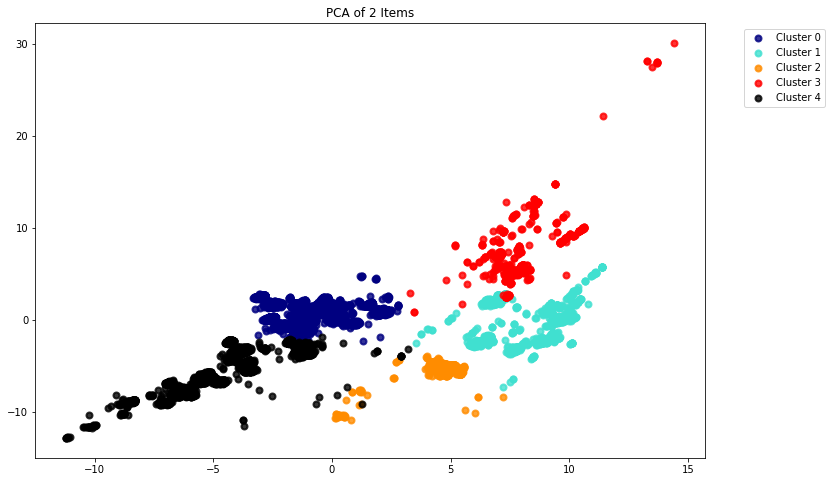

In [42]:
#call function
kmeans_pca(train)

Explained variance ratio (first two components): [0.11664989 0.08000834]


<Figure size 432x288 with 0 Axes>

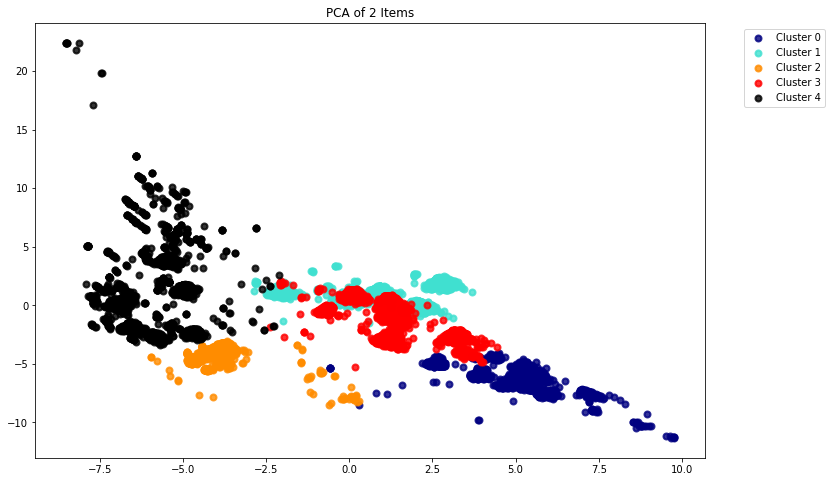

In [45]:
#call function
kmeans_pca(energy_df) #dataset preprocessed with additional dropped features

# Supervised Learning Methods

-------------------

I chose to use four algorithms but added an additional one based on the output.  I selected KNeighborsRegressor, RandomForestRegressor, and XGBoost.  I added CatBoost when I saw the results of the other algorithms, in the hopes that the categorical variable creating 60 features (less after pre-processing) could be managed by CatBoost better than the other models.  CatBoost doesn't require one-hot-encoding of categorical variables, it encodes it within the model.  As a result, CatBoost was more performant than any of the other models.

## Pipelines and Hyperparameter tuning (GridSearchCV)

#### Note: This function captures the pipeline and grid search, but due to the minimal computational power of my computer I will do a simplified gridsearch outside of this function to narrow down the best parameters.

#### preprocessed dataset

In [ ]:
X = train.drop(['site_eui'],axis=1)
y = train['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)

#### preprocessed dataset after additional feature elimination

In [8]:
X = energy_df.drop(['site_eui'],axis=1)
y = energy_df['site_eui']
# sc = StandardScaler()
# X = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)

In [18]:

def supervised_analysis(model):
    
    pipe = Pipeline([
        ('scaler',StandardScaler()),
        #PCA explained variance threshold as value rather than count
        ('reducer',PCA(n_components=0.95)), 
        ('regressor',model)]) 

    pipe.fit(X_train, y_train)

    '''the parameters not pertaining to the specific model run were commented out where appropriate '''

    #when using kNeighbors
    parameters = {"regressor__n_neighbors": [21,23]}
    #when using Random Forest
    parameters = {"regressor__max_depth": [20],
                  #"regressor__min_samples_leaf": [0.001],
                  "regressor__max_features": [35],
                  "regressor__random_state":[44],
                  "regressor__max_leaf_nodes":[500],
                  #"regressor__min_impurity_decrease":[0.0],
                  "regressor__bootstrap":[True],
                  "regressor__oob_score": [True,False]}
   
    print(f'Running the {model} analysis now...')

    grid = GridSearchCV(pipe, 
                        param_grid=parameters, 
                        cv=4,
                        scoring ="neg_root_mean_squared_error",
                        n_jobs=-1,
                        verbose=1).fit(X_train, y_train)

    #test for over or underfitting
    print('Evaluating over and underfitting...')
    print('Grid training set score after tuning: '+ str(abs(grid.score(X_train,y_train))))
    print('Grid test set score after tuning: '+ str(abs(grid.score(X_test,y_test))))

    # Access the best set of parameters
    best_params = grid.best_params_
    print(best_params)
    # Stores the optimum model in best_pipe
    best_pipe = grid.best_estimator_
    print(best_pipe)

    best_params = grid.best_params_
    best_rmse = abs(grid.best_score_)

    # Print the tuned parameters and score
    print(f'Tuned {model} Parameters: {best_params}')
    print(f'Best {model} RMSE: {best_rmse}')

### K Neighbors Regressor

Results of modifying PCA value for KNeighborsRegressor:

- 80% PCA: RMSE = 46.78
- 90% PCA: RMSE = 46.79
- 95% PCA: RMSE = 46.38
- overfitting/underfitting: train = 43.7, test = 47.7 (when PCA = 95%)

In [11]:
#run function
supervised_analysis(KNeighborsRegressor())

Running the KNeighborsRegressor() analysis now...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Evaluating over and underfitting...
Grid training set score after tuning: 43.69111863101502
Grid test set score after tuning: 47.742178205056895
{'regressor__n_neighbors': 23}
Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=0.95)),
                ('regressor', KNeighborsRegressor(n_neighbors=23))])
Tuned KNeighborsRegressor() Parameters: {'regressor__n_neighbors': 23}
Best KNeighborsRegressor() RMSE: 46.38312350968433


### run energy dataframe (dropped fields) and standardscaler, and testing best K to put into model above

In [6]:
# Test several values for the n_neighbors

X = energy_df.drop(['site_eui'],axis=1)
y = energy_df['site_eui']
sc = StandardScaler()
X = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)

rmse_list = []
K_list = []
#loop through k range
for k in range(3,50):
    # use odds(no ties)
    if k%2 !=0:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        rmse = np.sqrt(MSE(y_test,y_pred_knn))
        rmse_list.append(rmse)
        K_list.append(k)

# Create data frame that contains the values from our two lists
knn_df = pd.DataFrame({'RMSE Score':rmse_list,'K': K_list})

knn_sort = knn_df.sort_values(['RMSE Score','K'], ascending=[True,True], ignore_index=True)
print(knn_sort.loc[0])

RMSE Score    47.772458
K             23.000000
Name: 0, dtype: float64


In [10]:
#run function
#running again but with energy dataset - fewer features, better results??

supervised_analysis(KNeighborsRegressor())

Running the KNeighborsRegressor() analysis now...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Evaluating over and underfitting...
Grid training set score after tuning: 43.710499260133844
Grid test set score after tuning: 47.66826789790492
{'regressor__n_neighbors': 23}
Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=0.95)),
                ('regressor', KNeighborsRegressor(n_neighbors=23))])
Tuned KNeighborsRegressor() Parameters: {'regressor__n_neighbors': 23}
Best KNeighborsRegressor() RMSE: 46.40249730131106


In [17]:
#test normalize
X = energy_df.drop(['site_eui'],axis=1)
y = energy_df['site_eui']
X = normalize(X,axis=0)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)

rmse_list = []
K_list = []
#loop through k range
for k in range(3,50):
    # use odds(no ties)
    if k%2 !=0:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        rmse = np.sqrt(MSE(y_test,y_pred_knn))
        rmse_list.append(rmse)
        K_list.append(k)

# Create data frame that contains the values from our two lists
knn_df = pd.DataFrame({'RMSE Score':rmse_list,'K': K_list})

knn_sort = knn_df.sort_values(['RMSE Score','K'], ascending=[True,True], ignore_index=True)
print(knn_sort.loc[0])


RMSE Score    48.396327
K             21.000000
Name: 0, dtype: float64


In [19]:
#no pca
#energy df
#normalized data got 21 neighbors, test 21 and 23
#cv=4
#keep scaler in pipeline

supervised_analysis(KNeighborsRegressor())

Running the KNeighborsRegressor() analysis now...
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Evaluating over and underfitting...
Grid training set score after tuning: 43.65039434580353
Grid test set score after tuning: 47.76729950061129
{'regressor__n_neighbors': 21}
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=21))])
Tuned KNeighborsRegressor() Parameters: {'regressor__n_neighbors': 21}
Best KNeighborsRegressor() RMSE: 46.00418566981621


In [12]:
#run function
#running again but with energy dataset - fewer features, better results??
#no pca
supervised_analysis(KNeighborsRegressor())

Running the KNeighborsRegressor() analysis now...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Evaluating over and underfitting...
Grid training set score after tuning: 43.7776778965317
Grid test set score after tuning: 47.78022723741379
{'regressor__n_neighbors': 23}
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=23))])
Tuned KNeighborsRegressor() Parameters: {'regressor__n_neighbors': 23}
Best KNeighborsRegressor() RMSE: 46.57280575643162


In [14]:
#run function
#running again but with energy dataset - fewer features, better results??
#no pca
#add more folds =4 
supervised_analysis(KNeighborsRegressor())

Running the KNeighborsRegressor() analysis now...
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Evaluating over and underfitting...
Grid training set score after tuning: 43.7776778965317
Grid test set score after tuning: 47.78022723741379
{'regressor__n_neighbors': 23}
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=23))])
Tuned KNeighborsRegressor() Parameters: {'regressor__n_neighbors': 23}
Best KNeighborsRegressor() RMSE: 46.00786564314183


In [16]:
#X_norm = normalize(X,axis=0)
#run function
#running again but with energy dataset - fewer features, better results??
#no pca
#add more folds =10
supervised_analysis(KNeighborsRegressor())

Running the KNeighborsRegressor() analysis now...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Evaluating over and underfitting...
Grid training set score after tuning: 43.7776778965317
Grid test set score after tuning: 47.78022723741379
{'regressor__n_neighbors': 23}
Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=23))])
Tuned KNeighborsRegressor() Parameters: {'regressor__n_neighbors': 23}
Best KNeighborsRegressor() RMSE: 45.76227881538483


## Random Forest Regressor

In [17]:
supervised_analysis(RandomForestRegressor())

Running the RandomForestRegressor() analysis now...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Evaluating over and underfitting...
Grid training set score after tuning: 31.034831366360756
Grid test set score after tuning: 47.16853395661603
{'regressor__bootstrap': True, 'regressor__max_depth': 20, 'regressor__max_features': 35, 'regressor__max_leaf_nodes': 500, 'regressor__oob_score': True, 'regressor__random_state': 44}
Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=0.95)),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features=35,
                                       max_leaf_nodes=500, oob_score=True,
                                       random_state=44))])
Tuned RandomForestRegressor() Parameters: {'regressor__bootstrap': True, 'regressor__max_depth': 20, 'regressor__max_features': 35, 'regressor__max_leaf_nodes': 500, 'regressor__oob_score': True, 'regressor__random_state': 44}

## XGBoost

Due to the computational requirements of the pipeline and grid search for numerous values in XGBoost (in the function above) I opted to narrow down the features using another function specific to XGBoost parameters.

In [22]:
#scale data
X = train.drop(['site_eui'],axis=1)
sc=StandardScaler()
X_sc = sc.fit_transform(X)
X_train_sc,X_test_sc,y_train,y_test = train_test_split(X_sc,y,test_size=0.3,random_state=44)

#normalize
X_e = energy_df.drop(['site_eui'],axis=1)
X_norm = normalize(X_e,axis=0)
X_train_norm,X_test_norm,y_train,y_test = train_test_split(X_norm,y,test_size=0.3,random_state=44)

y = train['site_eui']


def xgboost(X_train,X_test,y_train,y_test):
    print(f'XGBoost report:')
    
    gbm_param_grid = {'learning_rate': [0.1],
                    'n_estimators':[200,500,1000],
                    'subsample': [0.7,0.9],
                    'colsample_bytree':[0.7],
                    'max_depth': [11],
                    'reg_alpha': [0.0001,0.001]
                    }
    gbm = XGBRegressor()
    
    print(f'Running the XGBoost analysis now...')

    grid_xgb = GridSearchCV(estimator=gbm,
                            param_grid=gbm_param_grid,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            cv=4,
                            verbose=3)
    
    grid_xgb.fit(X_train,y_train)
    print('Best parameters found: ', grid_xgb.best_params_)
    print("lowest RMSE found: ",np.sqrt(np.abs(grid_xgb.best_score_)))
    
    
    #test for over or underfitting
    print('Evaluating over and underfitting...')
    print('Grid training set score after tuning: '+ str(abs(grid_xgb.score(X_train,y_train))))
    print('Grid test set score after tuning: '+ str(abs(grid_xgb.score(X_test,y_test))))

    # Access the best set of parameters
    best_params = grid_xgb.best_params_
    print(best_params)
    # Stores the optimum model in best_pipe
    best_pipe = grid_xgb.best_estimator_
    print(best_pipe)

    best_params = grid_xgb.best_params_
    best_rmse = abs(grid_xgb.best_score_)

    # Print the tuned parameters and score
    print(f'Tuned XGBoost Parameters: {best_params}')
    print(f'Best XGBoost RMSE: {best_rmse}')

In [23]:
#normalize
#use energy data
xgboost(X_train,X_test,y_train,y_test)

XGBoost report:
Running the XGBoost analysis now...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 1000, 'reg_alpha': 0.001, 'subsample': 0.9}
lowest RMSE found:  6.280401797461543
Evaluating over and underfitting...
Grid training set score after tuning: 8.28861302823339
Grid test set score after tuning: 39.19067142113127
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 1000, 'reg_alpha': 0.001, 'subsample': 0.9}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=11, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_para

In [35]:
#call function
xgboost(X_train,X_test,y_train,y_test)

#results:
# rmse: Best XGBoost RMSE: 39.28752174657032
# Evaluating over and underfitting...
# Grid training set score after tuning: 8.539093356766646
# Grid test set score after tuning: 39.12969780376884
#def overfitting

XGBoost report:
Running the XGBoost analysis now...
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 1000, 'reg_alpha': 0.001, 'subsample': 0.9}
lowest RMSE found:  6.267975889118458
Evaluating over and underfitting...
Grid training set score after tuning: 8.539093356766646
Grid test set score after tuning: 39.12969780376884
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 1000, 'reg_alpha': 0.001, 'subsample': 0.9}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=11, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_para

#### output and notes

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 1000, 'subsample': 0.9}
lowest RMSE found:  39.43352789205589

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.9}
lowest RMSE found:  39.51693811723923

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 900, 'subsample': 0.9}
lowest RMSE found:  39.513904528498436

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 800, 'subsample': 0.9}
lowest RMSE found:  39.57005311266341

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 700, 'subsample': 0.9}
lowest RMSE found:  39.69723628854447

#Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.9}
#lowest RMSE found:  40.34806500753284


grid_param_pipe = {'PCA__n_components': [2],
                   'XGB__n_estimators': [200,300],
                   'XGB__max_depth': [2,3],
                   'XGB__reg_alpha': [0.1],
                   'XGB__reg_lambda': [0.1],
                   'XGB__colsample_bytree': [0.3],
                   'XGB__subsample': [0.7],
                   
 Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}
lowest RMSE found:  41.35765987979435

### CatBoost

CatBoost is unique in that it can handle categorical features.  It encodes them for the model, but only requires the user to select the fields that are categorical.  One additional requirement of CatBoost is non-negative values, which meant that I needed to convert the temperature values in the dataset because many were negative - but MinMaxScaler was used to tranform the values and run the model.  This model was more performant but it comes at a cost of some overfitting.

In [3]:
catboost_df = pd.read_csv('train_before_ohe.csv')

In [4]:
#columns with negative values - catboost doesn't handle negatives, must convert

def scale_data(data,columns,scaler):
    for col in columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
    return data

columns = ['temp01','temp02','temp03','temp04','temp05','temp06','temp07', 'temp08','temp09','temp10','temp11','temp12']

scale_data(catboost_df, columns, MinMaxScaler())

,Unnamed: 0,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
0,0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,115,...,0.736569,0.554350,0.405186,0.354274,0.277400,0.242879,0.425535,0.526141,0.648321,0.726062
1,1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,115,...,0.736569,0.554350,0.405186,0.354274,0.277400,0.242879,0.425535,0.526141,0.648321,0.726062
2,2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,115,...,0.736569,0.554350,0.405186,0.354274,0.277400,0.242879,0.425535,0.526141,0.648321,0.726062
3,3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,115,...,0.736569,0.554350,0.405186,0.354274,0.277400,0.242879,0.425535,0.526141,0.648321,0.726062
4,4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,115,...,0.736569,0.554350,0.405186,0.354274,0.277400,0.242879,0.425535,0.526141,0.648321,0.726062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75742,75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,260,...,0.602615,0.658658,0.458069,0.364276,0.355181,0.349112,0.210433,0.240169,0.590472,0.386841
75743,75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,260,...,0.602615,0.658658,0.458069,0.364276,0.355181,0.349112,0.210433,0.240169,0.590472,0.386841
75744,75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,67.0,36.6,55,...,0.434496,0.444714,0.249573,0.192374,0.184933,0.221137,0.050072,0.065090,0.398432,0.210701
75745,75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,67.0,36.6,55,...,0.434496,0.444714,0.249573,0.192374,0.184933,0.221137,0.050072,0.065090,0.398432,0.210701


In [5]:
catboost_df = catboost_df.drop(['Unnamed: 0'],axis=1)

In [8]:
#split data into categorical and numeric to standardize the numeric, then join back together
cats = catboost_df[['State_Factor','building_class','facility_type']]
cats.head()

,State_Factor,building_class,facility_type
0,State_1,Commercial,Grocery_store_or_food_market
1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center
2,State_1,Commercial,Retail_Enclosed_mall
3,State_1,Commercial,Education_Other_classroom
4,State_1,Commercial,Warehouse_Nonrefrigerated


In [9]:
#drop categorical to normalize and standardize the numeric data
X = catboost_df.drop(['State_Factor','building_class','facility_type','site_eui'],axis=1)
X.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
0,1,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,...,0.736569,0.55435,0.405186,0.354274,0.2774,0.242879,0.425535,0.526141,0.648321,0.726062
1,1,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,...,0.736569,0.55435,0.405186,0.354274,0.2774,0.242879,0.425535,0.526141,0.648321,0.726062
2,1,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,...,0.736569,0.55435,0.405186,0.354274,0.2774,0.242879,0.425535,0.526141,0.648321,0.726062
3,1,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,...,0.736569,0.55435,0.405186,0.354274,0.2774,0.242879,0.425535,0.526141,0.648321,0.726062
4,1,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,...,0.736569,0.55435,0.405186,0.354274,0.2774,0.242879,0.425535,0.526141,0.648321,0.726062


In [10]:
X_norm = normalize(X,axis=0)
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [17]:
X_norm_df = pd.DataFrame(X_norm)
X_norm_concat = pd.concat([X_norm_df,cats],axis=1)
X_norm_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,State_Factor,building_class,facility_type
0,0.000788,0.000748,0.003613,0.000594,0.00012,0.00033,0.002443,0.001378,0.0,0.0,...,0.002675,0.001765,0.001824,0.00313,0.004794,0.004939,0.004986,State_1,Commercial,Grocery_store_or_food_market
1,0.000788,0.003346,0.003638,0.002430,0.00009,0.00033,0.002443,0.001378,0.0,0.0,...,0.002675,0.001765,0.001824,0.00313,0.004794,0.004939,0.004986,State_1,Commercial,Warehouse_Distribution_or_Shipping_center
2,0.000788,0.003420,0.003630,0.005238,0.00009,0.00033,0.002443,0.001378,0.0,0.0,...,0.002675,0.001765,0.001824,0.00313,0.004794,0.004939,0.004986,State_1,Commercial,Retail_Enclosed_mall
3,0.000788,0.000676,0.003684,0.002484,0.00009,0.00033,0.002443,0.001378,0.0,0.0,...,0.002675,0.001765,0.001824,0.00313,0.004794,0.004939,0.004986,State_1,Commercial,Education_Other_classroom
4,0.000788,0.000806,0.003693,0.005400,0.00012,0.00033,0.002443,0.001378,0.0,0.0,...,0.002675,0.001765,0.001824,0.00313,0.004794,0.004939,0.004986,State_1,Commercial,Warehouse_Nonrefrigerated


In [19]:
X_scaled_df = pd.DataFrame(X_scaled)
X_scaled_concat = pd.concat([X_scaled_df,cats],axis=1)
X_scaled_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,State_Factor,building_class,facility_type
0,-2.288904,-0.424225,-0.328187,-2.244024,-0.611736,-2.776539,-1.655667,-2.439561,-1.635818,-0.940572,...,-1.952765,-3.149724,-2.61374,-0.540814,1.42479,1.635194,1.487956,State_1,Commercial,Grocery_store_or_food_market
1,-2.288904,0.437533,0.078222,-0.780884,-0.621628,-2.776539,-1.655667,-2.439561,-1.635818,-0.940572,...,-1.952765,-3.149724,-2.61374,-0.540814,1.42479,1.635194,1.487956,State_1,Commercial,Warehouse_Distribution_or_Shipping_center
2,-2.288904,0.461937,-0.046827,1.456858,-0.621628,-2.776539,-1.655667,-2.439561,-1.635818,-0.940572,...,-1.952765,-3.149724,-2.61374,-0.540814,1.42479,1.635194,1.487956,State_1,Commercial,Retail_Enclosed_mall
3,-2.288904,-0.448192,0.859778,-0.737851,-0.621628,-2.776539,-1.655667,-2.439561,-1.635818,-0.940572,...,-1.952765,-3.149724,-2.61374,-0.540814,1.42479,1.635194,1.487956,State_1,Commercial,Education_Other_classroom
4,-2.288904,-0.404953,1.016089,1.585959,-0.611736,-2.776539,-1.655667,-2.439561,-1.635818,-0.940572,...,-1.952765,-3.149724,-2.61374,-0.540814,1.42479,1.635194,1.487956,State_1,Commercial,Warehouse_Nonrefrigerated


In [25]:
#train-test-split
#scaled
y = catboost_df['site_eui']
X_train_sc,X_test_sc,y_train,y_test = train_test_split(X_scaled_concat,y,test_size=0.3,random_state=44)

In [26]:
#train-test-split
#normalized
y = catboost_df['site_eui']
X_train_norm,X_test_norm,y_train,y_test = train_test_split(X_norm_concat,y,test_size=0.3,random_state=44)

#### data prepped and model ready to run

In [28]:
#keep
def catboost(X_train,X_test,y_train,y_test,iterations,lr):
    cat_features = [31,32,33]
    model = CatBoostRegressor(iterations=iterations,learning_rate=lr,loss_function='RMSE',eval_metric='RMSE',random_seed=44)
    model.fit(X_train,y_train,cat_features=cat_features,verbose=True)
    print(model.get_best_score())

    print('Evaluating over and underfitting (using R2 only)...')
    print('Grid training set score after tuning: '+ str(abs(model.score(X_train,y_train))))
    print('Grid test set score after tuning: '+ str(abs(model.score(X_test,y_test))))



In [29]:
#normalized
catboost(X_train_norm,X_test_norm,y_train,y_test,1000,0.5)

# {'learn': {'RMSE': 28.951127002323364}}
# Evaluating over and underfitting (using R2 only)...
# Grid training set score after tuning: 0.7059543969289848
# Grid test set score after tuning: 0.4404579396623016

0:	learn: 50.2362317	total: 62.1ms	remaining: 1m 2s
1:	learn: 47.9569468	total: 106ms	remaining: 52.6s
2:	learn: 46.5293968	total: 148ms	remaining: 49.3s
3:	learn: 45.7000729	total: 209ms	remaining: 51.9s
4:	learn: 45.1442364	total: 254ms	remaining: 50.6s
5:	learn: 44.8635299	total: 308ms	remaining: 50.9s
6:	learn: 44.5487076	total: 347ms	remaining: 49.3s
7:	learn: 44.3473657	total: 395ms	remaining: 49s
8:	learn: 44.1554755	total: 436ms	remaining: 48s
9:	learn: 43.9932872	total: 483ms	remaining: 47.8s
10:	learn: 43.8337625	total: 538ms	remaining: 48.4s
11:	learn: 43.7408185	total: 605ms	remaining: 49.8s
12:	learn: 43.7034890	total: 653ms	remaining: 49.6s
13:	learn: 43.6152586	total: 705ms	remaining: 49.6s
14:	learn: 43.4535087	total: 745ms	remaining: 48.9s
15:	learn: 43.3894839	total: 798ms	remaining: 49.1s
16:	learn: 43.1079925	total: 846ms	remaining: 48.9s
17:	learn: 43.0005054	total: 889ms	remaining: 48.5s
18:	learn: 42.8751865	total: 927ms	remaining: 47.9s
19:	learn: 42.7476313	tot

158:	learn: 37.5406911	total: 7.31s	remaining: 38.7s
159:	learn: 37.5139009	total: 7.37s	remaining: 38.7s
160:	learn: 37.5120321	total: 7.42s	remaining: 38.7s
161:	learn: 37.4962500	total: 7.46s	remaining: 38.6s
162:	learn: 37.4743450	total: 7.51s	remaining: 38.6s
163:	learn: 37.4515746	total: 7.55s	remaining: 38.5s
164:	learn: 37.4290726	total: 7.59s	remaining: 38.4s
165:	learn: 37.3588800	total: 7.63s	remaining: 38.3s
166:	learn: 37.3372064	total: 7.69s	remaining: 38.3s
167:	learn: 37.2897211	total: 7.74s	remaining: 38.3s
168:	learn: 37.2704163	total: 7.8s	remaining: 38.4s
169:	learn: 37.2529349	total: 7.85s	remaining: 38.3s
170:	learn: 37.2348204	total: 7.88s	remaining: 38.2s
171:	learn: 37.2319401	total: 7.94s	remaining: 38.2s
172:	learn: 37.2226765	total: 7.98s	remaining: 38.1s
173:	learn: 37.1888472	total: 8.03s	remaining: 38.1s
174:	learn: 37.1765606	total: 8.07s	remaining: 38.1s
175:	learn: 37.1597286	total: 8.11s	remaining: 38s
176:	learn: 37.1533764	total: 8.17s	remaining: 38

317:	learn: 34.7536127	total: 14.9s	remaining: 31.9s
318:	learn: 34.7356576	total: 14.9s	remaining: 31.9s
319:	learn: 34.7311443	total: 15s	remaining: 31.8s
320:	learn: 34.7160260	total: 15s	remaining: 31.7s
321:	learn: 34.7043137	total: 15.1s	remaining: 31.7s
322:	learn: 34.6946427	total: 15.1s	remaining: 31.7s
323:	learn: 34.6874850	total: 15.1s	remaining: 31.6s
324:	learn: 34.6859491	total: 15.2s	remaining: 31.6s
325:	learn: 34.6824016	total: 15.2s	remaining: 31.5s
326:	learn: 34.6286928	total: 15.3s	remaining: 31.5s
327:	learn: 34.6105080	total: 15.3s	remaining: 31.4s
328:	learn: 34.5865448	total: 15.4s	remaining: 31.4s
329:	learn: 34.5700266	total: 15.4s	remaining: 31.3s
330:	learn: 34.5664301	total: 15.5s	remaining: 31.3s
331:	learn: 34.5653081	total: 15.5s	remaining: 31.2s
332:	learn: 34.5625202	total: 15.6s	remaining: 31.2s
333:	learn: 34.5545126	total: 15.6s	remaining: 31.1s
334:	learn: 34.5459636	total: 15.7s	remaining: 31.1s
335:	learn: 34.5424258	total: 15.7s	remaining: 31s

473:	learn: 32.8816199	total: 22s	remaining: 24.5s
474:	learn: 32.8624276	total: 22.1s	remaining: 24.4s
475:	learn: 32.8459727	total: 22.1s	remaining: 24.4s
476:	learn: 32.8140113	total: 22.2s	remaining: 24.3s
477:	learn: 32.8099482	total: 22.2s	remaining: 24.3s
478:	learn: 32.7829382	total: 22.3s	remaining: 24.2s
479:	learn: 32.7803203	total: 22.3s	remaining: 24.2s
480:	learn: 32.7564216	total: 22.4s	remaining: 24.2s
481:	learn: 32.7544177	total: 22.4s	remaining: 24.1s
482:	learn: 32.7522905	total: 22.5s	remaining: 24.1s
483:	learn: 32.7397630	total: 22.5s	remaining: 24s
484:	learn: 32.7343411	total: 22.6s	remaining: 24s
485:	learn: 32.7274477	total: 22.6s	remaining: 23.9s
486:	learn: 32.7243214	total: 22.7s	remaining: 23.9s
487:	learn: 32.7064577	total: 22.7s	remaining: 23.9s
488:	learn: 32.6928948	total: 22.8s	remaining: 23.8s
489:	learn: 32.6822060	total: 22.8s	remaining: 23.8s
490:	learn: 32.6774218	total: 22.9s	remaining: 23.7s
491:	learn: 32.6515012	total: 22.9s	remaining: 23.7s

632:	learn: 31.2800212	total: 29.5s	remaining: 17.1s
633:	learn: 31.2662398	total: 29.6s	remaining: 17.1s
634:	learn: 31.2609762	total: 29.6s	remaining: 17s
635:	learn: 31.2560389	total: 29.6s	remaining: 17s
636:	learn: 31.2439022	total: 29.7s	remaining: 16.9s
637:	learn: 31.2413821	total: 29.7s	remaining: 16.9s
638:	learn: 31.2393271	total: 29.8s	remaining: 16.8s
639:	learn: 31.2270445	total: 29.8s	remaining: 16.8s
640:	learn: 31.2215253	total: 29.9s	remaining: 16.7s
641:	learn: 31.2212651	total: 29.9s	remaining: 16.7s
642:	learn: 31.2097130	total: 30s	remaining: 16.6s
643:	learn: 31.1982461	total: 30s	remaining: 16.6s
644:	learn: 31.1943937	total: 30.1s	remaining: 16.5s
645:	learn: 31.1870277	total: 30.1s	remaining: 16.5s
646:	learn: 31.1754987	total: 30.2s	remaining: 16.5s
647:	learn: 31.1697524	total: 30.2s	remaining: 16.4s
648:	learn: 31.1596023	total: 30.2s	remaining: 16.4s
649:	learn: 31.1541758	total: 30.3s	remaining: 16.3s
650:	learn: 31.1273591	total: 30.3s	remaining: 16.3s
6

793:	learn: 30.1165681	total: 36.9s	remaining: 9.56s
794:	learn: 30.1160944	total: 36.9s	remaining: 9.52s
795:	learn: 30.1087623	total: 37s	remaining: 9.47s
796:	learn: 30.1070455	total: 37s	remaining: 9.43s
797:	learn: 30.0972453	total: 37.1s	remaining: 9.38s
798:	learn: 30.0954190	total: 37.1s	remaining: 9.33s
799:	learn: 30.0926557	total: 37.1s	remaining: 9.28s
800:	learn: 30.0850050	total: 37.2s	remaining: 9.23s
801:	learn: 30.0835278	total: 37.2s	remaining: 9.19s
802:	learn: 30.0821487	total: 37.3s	remaining: 9.14s
803:	learn: 30.0780953	total: 37.3s	remaining: 9.1s
804:	learn: 30.0728677	total: 37.4s	remaining: 9.05s
805:	learn: 30.0657932	total: 37.4s	remaining: 9.01s
806:	learn: 30.0635286	total: 37.5s	remaining: 8.96s
807:	learn: 30.0546417	total: 37.5s	remaining: 8.91s
808:	learn: 30.0523281	total: 37.6s	remaining: 8.87s
809:	learn: 30.0456983	total: 37.6s	remaining: 8.82s
810:	learn: 30.0402987	total: 37.7s	remaining: 8.78s
811:	learn: 30.0344179	total: 37.7s	remaining: 8.73

953:	learn: 29.1761697	total: 44.3s	remaining: 2.13s
954:	learn: 29.1557400	total: 44.3s	remaining: 2.09s
955:	learn: 29.1489879	total: 44.3s	remaining: 2.04s
956:	learn: 29.1479057	total: 44.4s	remaining: 1.99s
957:	learn: 29.1406285	total: 44.4s	remaining: 1.95s
958:	learn: 29.1349944	total: 44.5s	remaining: 1.9s
959:	learn: 29.1340132	total: 44.5s	remaining: 1.85s
960:	learn: 29.1300999	total: 44.6s	remaining: 1.81s
961:	learn: 29.1255676	total: 44.6s	remaining: 1.76s
962:	learn: 29.1236422	total: 44.7s	remaining: 1.72s
963:	learn: 29.1137135	total: 44.7s	remaining: 1.67s
964:	learn: 29.1108465	total: 44.8s	remaining: 1.62s
965:	learn: 29.1086304	total: 44.8s	remaining: 1.58s
966:	learn: 29.1065590	total: 44.9s	remaining: 1.53s
967:	learn: 29.1047651	total: 44.9s	remaining: 1.49s
968:	learn: 29.1002602	total: 45s	remaining: 1.44s
969:	learn: 29.0969975	total: 45s	remaining: 1.39s
970:	learn: 29.0911370	total: 45.1s	remaining: 1.35s
971:	learn: 29.0868215	total: 45.1s	remaining: 1.3s

In [30]:
#standardized
catboost(X_train_sc,X_test_sc,y_train,y_test,1000,0.5)
# {'learn': {'RMSE': 28.951127002323364}}
# Evaluating over and underfitting (using R2 only)...
# Grid training set score after tuning: 0.7059543969289848
# Grid test set score after tuning: 0.4404579396623016

0:	learn: 50.2362317	total: 44.8ms	remaining: 44.7s
1:	learn: 47.9569468	total: 91ms	remaining: 45.4s
2:	learn: 46.5293968	total: 142ms	remaining: 47.3s
3:	learn: 45.7000729	total: 198ms	remaining: 49.4s
4:	learn: 45.1442364	total: 243ms	remaining: 48.4s
5:	learn: 44.8635299	total: 282ms	remaining: 46.7s
6:	learn: 44.5487076	total: 329ms	remaining: 46.6s
7:	learn: 44.3473657	total: 367ms	remaining: 45.5s
8:	learn: 44.1554755	total: 418ms	remaining: 46.1s
9:	learn: 43.9932872	total: 459ms	remaining: 45.5s
10:	learn: 43.8337625	total: 506ms	remaining: 45.5s
11:	learn: 43.7408185	total: 543ms	remaining: 44.7s
12:	learn: 43.7034890	total: 599ms	remaining: 45.4s
13:	learn: 43.6152586	total: 645ms	remaining: 45.4s
14:	learn: 43.4535087	total: 684ms	remaining: 44.9s
15:	learn: 43.3894839	total: 747ms	remaining: 45.9s
16:	learn: 43.1079925	total: 795ms	remaining: 46s
17:	learn: 43.0005054	total: 849ms	remaining: 46.3s
18:	learn: 42.8751865	total: 910ms	remaining: 47s
19:	learn: 42.7476313	tota

159:	learn: 37.5139009	total: 7.32s	remaining: 38.4s
160:	learn: 37.5120321	total: 7.37s	remaining: 38.4s
161:	learn: 37.4962500	total: 7.4s	remaining: 38.3s
162:	learn: 37.4743450	total: 7.45s	remaining: 38.3s
163:	learn: 37.4515746	total: 7.49s	remaining: 38.2s
164:	learn: 37.4290726	total: 7.54s	remaining: 38.2s
165:	learn: 37.3588800	total: 7.6s	remaining: 38.2s
166:	learn: 37.3372064	total: 7.64s	remaining: 38.1s
167:	learn: 37.2897211	total: 7.69s	remaining: 38.1s
168:	learn: 37.2704163	total: 7.76s	remaining: 38.1s
169:	learn: 37.2529349	total: 7.8s	remaining: 38.1s
170:	learn: 37.2348204	total: 7.84s	remaining: 38s
171:	learn: 37.2319401	total: 7.89s	remaining: 38s
172:	learn: 37.2226765	total: 7.94s	remaining: 38s
173:	learn: 37.1888472	total: 7.99s	remaining: 37.9s
174:	learn: 37.1765606	total: 8.04s	remaining: 37.9s
175:	learn: 37.1597286	total: 8.09s	remaining: 37.9s
176:	learn: 37.1533764	total: 8.14s	remaining: 37.9s
177:	learn: 37.1307523	total: 8.18s	remaining: 37.8s
17

318:	learn: 34.7356576	total: 14.6s	remaining: 31.3s
319:	learn: 34.7311443	total: 14.7s	remaining: 31.2s
320:	learn: 34.7160260	total: 14.7s	remaining: 31.2s
321:	learn: 34.7043137	total: 14.8s	remaining: 31.1s
322:	learn: 34.6946427	total: 14.8s	remaining: 31.1s
323:	learn: 34.6874850	total: 14.9s	remaining: 31s
324:	learn: 34.6859491	total: 14.9s	remaining: 31s
325:	learn: 34.6824016	total: 15s	remaining: 31s
326:	learn: 34.6286928	total: 15s	remaining: 30.9s
327:	learn: 34.6105080	total: 15.1s	remaining: 30.9s
328:	learn: 34.5865448	total: 15.1s	remaining: 30.9s
329:	learn: 34.5700266	total: 15.2s	remaining: 30.8s
330:	learn: 34.5664301	total: 15.2s	remaining: 30.7s
331:	learn: 34.5653081	total: 15.2s	remaining: 30.7s
332:	learn: 34.5625202	total: 15.3s	remaining: 30.6s
333:	learn: 34.5545126	total: 15.3s	remaining: 30.6s
334:	learn: 34.5459636	total: 15.4s	remaining: 30.5s
335:	learn: 34.5424258	total: 15.4s	remaining: 30.5s
336:	learn: 34.5355421	total: 15.5s	remaining: 30.4s
337

476:	learn: 32.8140113	total: 21.9s	remaining: 24s
477:	learn: 32.8099482	total: 21.9s	remaining: 23.9s
478:	learn: 32.7829382	total: 22s	remaining: 23.9s
479:	learn: 32.7803203	total: 22s	remaining: 23.8s
480:	learn: 32.7564216	total: 22.1s	remaining: 23.8s
481:	learn: 32.7544177	total: 22.1s	remaining: 23.8s
482:	learn: 32.7522905	total: 22.2s	remaining: 23.7s
483:	learn: 32.7397630	total: 22.2s	remaining: 23.7s
484:	learn: 32.7343411	total: 22.3s	remaining: 23.7s
485:	learn: 32.7274477	total: 22.3s	remaining: 23.6s
486:	learn: 32.7243214	total: 22.4s	remaining: 23.6s
487:	learn: 32.7064577	total: 22.4s	remaining: 23.5s
488:	learn: 32.6928948	total: 22.5s	remaining: 23.5s
489:	learn: 32.6822060	total: 22.5s	remaining: 23.4s
490:	learn: 32.6774218	total: 22.6s	remaining: 23.4s
491:	learn: 32.6515012	total: 22.6s	remaining: 23.3s
492:	learn: 32.6450044	total: 22.7s	remaining: 23.3s
493:	learn: 32.6297378	total: 22.7s	remaining: 23.3s
494:	learn: 32.6293950	total: 22.8s	remaining: 23.2s

636:	learn: 31.2439022	total: 29.1s	remaining: 16.6s
637:	learn: 31.2413821	total: 29.2s	remaining: 16.5s
638:	learn: 31.2393271	total: 29.2s	remaining: 16.5s
639:	learn: 31.2270445	total: 29.2s	remaining: 16.5s
640:	learn: 31.2215253	total: 29.3s	remaining: 16.4s
641:	learn: 31.2212651	total: 29.3s	remaining: 16.4s
642:	learn: 31.2097130	total: 29.4s	remaining: 16.3s
643:	learn: 31.1982461	total: 29.4s	remaining: 16.3s
644:	learn: 31.1943937	total: 29.5s	remaining: 16.2s
645:	learn: 31.1870277	total: 29.5s	remaining: 16.2s
646:	learn: 31.1754987	total: 29.5s	remaining: 16.1s
647:	learn: 31.1697524	total: 29.6s	remaining: 16.1s
648:	learn: 31.1596023	total: 29.6s	remaining: 16s
649:	learn: 31.1541758	total: 29.7s	remaining: 16s
650:	learn: 31.1273591	total: 29.7s	remaining: 15.9s
651:	learn: 31.1244968	total: 29.8s	remaining: 15.9s
652:	learn: 31.1208374	total: 29.8s	remaining: 15.8s
653:	learn: 31.1184214	total: 29.8s	remaining: 15.8s
654:	learn: 31.1183123	total: 29.9s	remaining: 15.

794:	learn: 30.1160944	total: 36.3s	remaining: 9.36s
795:	learn: 30.1087623	total: 36.4s	remaining: 9.32s
796:	learn: 30.1070455	total: 36.4s	remaining: 9.28s
797:	learn: 30.0972453	total: 36.5s	remaining: 9.23s
798:	learn: 30.0954190	total: 36.5s	remaining: 9.18s
799:	learn: 30.0926557	total: 36.5s	remaining: 9.14s
800:	learn: 30.0850050	total: 36.6s	remaining: 9.09s
801:	learn: 30.0835278	total: 36.7s	remaining: 9.05s
802:	learn: 30.0821487	total: 36.7s	remaining: 9s
803:	learn: 30.0780953	total: 36.7s	remaining: 8.95s
804:	learn: 30.0728677	total: 36.8s	remaining: 8.91s
805:	learn: 30.0657932	total: 36.8s	remaining: 8.86s
806:	learn: 30.0635286	total: 36.9s	remaining: 8.81s
807:	learn: 30.0546417	total: 36.9s	remaining: 8.77s
808:	learn: 30.0523281	total: 37s	remaining: 8.73s
809:	learn: 30.0456983	total: 37s	remaining: 8.68s
810:	learn: 30.0402987	total: 37.1s	remaining: 8.64s
811:	learn: 30.0344179	total: 37.1s	remaining: 8.6s
812:	learn: 30.0319774	total: 37.2s	remaining: 8.55s
8

950:	learn: 29.1858426	total: 44.4s	remaining: 2.29s
951:	learn: 29.1826671	total: 44.4s	remaining: 2.24s
952:	learn: 29.1791145	total: 44.5s	remaining: 2.19s
953:	learn: 29.1761697	total: 44.5s	remaining: 2.15s
954:	learn: 29.1557400	total: 44.6s	remaining: 2.1s
955:	learn: 29.1489879	total: 44.6s	remaining: 2.05s
956:	learn: 29.1479057	total: 44.7s	remaining: 2.01s
957:	learn: 29.1406285	total: 44.7s	remaining: 1.96s
958:	learn: 29.1349944	total: 44.8s	remaining: 1.91s
959:	learn: 29.1340132	total: 44.8s	remaining: 1.87s
960:	learn: 29.1300999	total: 44.9s	remaining: 1.82s
961:	learn: 29.1255676	total: 44.9s	remaining: 1.77s
962:	learn: 29.1236422	total: 45s	remaining: 1.73s
963:	learn: 29.1137135	total: 45s	remaining: 1.68s
964:	learn: 29.1108465	total: 45.1s	remaining: 1.63s
965:	learn: 29.1086304	total: 45.1s	remaining: 1.59s
966:	learn: 29.1065590	total: 45.2s	remaining: 1.54s
967:	learn: 29.1047651	total: 45.2s	remaining: 1.49s
968:	learn: 29.1002602	total: 45.3s	remaining: 1.45

In [31]:
#normalized
catboost(X_train_norm,X_test_norm,y_train,y_test,100,0.9)

# {'learn': {'RMSE': 38.091970439867396}}
# Evaluating over and underfitting (using R2 only)...
# Grid training set score after tuning: 0.5578830940624534
# Grid test set score after tuning: 0.38417545934718056

0:	learn: 51.4366784	total: 34.4ms	remaining: 3.4s
1:	learn: 47.1904230	total: 82.7ms	remaining: 4.05s
2:	learn: 46.3225697	total: 115ms	remaining: 3.71s
3:	learn: 45.8122525	total: 151ms	remaining: 3.63s
4:	learn: 45.3711476	total: 194ms	remaining: 3.68s
5:	learn: 45.0589520	total: 233ms	remaining: 3.65s
6:	learn: 44.7483293	total: 273ms	remaining: 3.63s
7:	learn: 44.4040690	total: 304ms	remaining: 3.49s
8:	learn: 44.0658199	total: 334ms	remaining: 3.38s
9:	learn: 43.9397903	total: 364ms	remaining: 3.27s
10:	learn: 43.7672063	total: 393ms	remaining: 3.18s
11:	learn: 43.5817818	total: 438ms	remaining: 3.21s
12:	learn: 43.5385036	total: 468ms	remaining: 3.13s
13:	learn: 43.2684128	total: 509ms	remaining: 3.13s
14:	learn: 43.1306801	total: 555ms	remaining: 3.14s
15:	learn: 42.9655825	total: 585ms	remaining: 3.07s
16:	learn: 42.7891408	total: 621ms	remaining: 3.03s
17:	learn: 42.6805762	total: 662ms	remaining: 3.02s
18:	learn: 42.6071205	total: 698ms	remaining: 2.97s
19:	learn: 42.5273469

In [32]:
#normalized
catboost(X_train_norm,X_test_norm,y_train,y_test,100,0.99)

0:	learn: 51.3636241	total: 43.8ms	remaining: 4.34s
1:	learn: 47.1778395	total: 81.4ms	remaining: 3.99s
2:	learn: 46.5065077	total: 110ms	remaining: 3.56s
3:	learn: 46.0912174	total: 141ms	remaining: 3.37s
4:	learn: 45.5336362	total: 176ms	remaining: 3.34s
5:	learn: 45.2446057	total: 213ms	remaining: 3.33s
6:	learn: 44.7214720	total: 246ms	remaining: 3.27s
7:	learn: 44.3641813	total: 284ms	remaining: 3.26s
8:	learn: 44.0215344	total: 321ms	remaining: 3.25s
9:	learn: 43.8580005	total: 370ms	remaining: 3.33s
10:	learn: 43.6548293	total: 424ms	remaining: 3.43s
11:	learn: 43.3893089	total: 458ms	remaining: 3.36s
12:	learn: 43.1588642	total: 498ms	remaining: 3.33s
13:	learn: 43.0352957	total: 549ms	remaining: 3.37s
14:	learn: 42.7785401	total: 580ms	remaining: 3.29s
15:	learn: 42.5494420	total: 622ms	remaining: 3.27s
16:	learn: 42.4398396	total: 652ms	remaining: 3.19s
17:	learn: 42.3019160	total: 683ms	remaining: 3.11s
18:	learn: 42.2295997	total: 717ms	remaining: 3.06s
19:	learn: 42.092072